In [1]:
import itertools
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from operator import itemgetter
from collections.abc import Iterable
import sys
import os

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

current_path = os.getcwd()
# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

# 1. Pre-processing

In [2]:
def preprocessing():
    df = pd.read_csv('./data/results.csv')
    df.head()
    
    df["date"] = pd.to_datetime(df["date"])
    df.dropna(inplace=True)
    df.sort_values("date")
    df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True) # consider games after the last worldcup
    df.head()
    
    rank = pd.read_csv("./data/fifa_ranking-2022-10-06.csv")
    rank["rank_date"] = pd.to_datetime(rank["rank_date"])
    rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)
    rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")
    
    rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
    df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
    df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)
    df = df_wc_ranked
    df = df.drop(['city', 'country', "neutral", "rank_change_home","total_points_home","total_points_away", "rank_change_away", "previous_points_away", "previous_points_home"], axis = 1)
    return df, rank
df, rank = preprocessing()
rank = rank.sort_values("rank_date").reset_index(drop = True)

df.head()

,date,home_team,away_team,home_score,away_score,tournament,rank_home,rank_away
0,2018-08-18,Andorra,United Arab Emirates,0.0,0.0,Friendly,130.0,77.0
1,2018-08-18,Grenada,Jamaica,1.0,5.0,Friendly,168.0,54.0
2,2018-08-18,Guatemala,Cuba,1.0,0.0,Friendly,146.0,181.0
3,2018-08-20,Barbados,Jamaica,2.0,2.0,Friendly,160.0,54.0
4,2018-08-26,Barbados,Cuba,0.0,0.0,Friendly,160.0,181.0


# 2. Feature Engineering


In [3]:
def result_finder(home, away):
    if home > away:
        # win of home corresponds to 0
        # + 3 for home team
        # + 0 for away team
        return pd.Series([1, 3, 0])
    if home < away:        
        # loss of home corresponds to 1
        # + 0 for home team
        # + 3 for away team
        return pd.Series([0, 0, 3])
    else:
        # draw corresponds to 2
        # +1 for home team
        # +1 for away team
        return pd.Series([2, 1, 1])
    
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0
    
def create_target(result, rank_dif):
    if result == 2:
        #if there is draw
        if rank_dif > 0:
            #away has higher ranking than home --> away wins
            return 1
        else:
            return 0
    elif result == 1:
        return 0
    
    return 1

In [4]:
tournament_typs = df["tournament"].unique()
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["is_friendly"] = df["tournament"].apply(lambda x: find_friendly(x)) 
df[["result", "home_team_points", "away_team_points"]] = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)
df["y"] = df.apply(lambda x: create_target(x["result"], x["rank_dif"]), axis=1)
dropped_columns = list(set(df.columns) - {'date', 'home_team','away_team',"is_friendly", 'y','rank_dif'})
team_stats_raw = df.copy() # useful for future simulation
df = df.drop(dropped_columns, axis = 1)
df

,date,home_team,away_team,rank_dif,is_friendly,y
0,2018-08-18,Andorra,United Arab Emirates,53.0,1,1
1,2018-08-18,Grenada,Jamaica,114.0,1,1
2,2018-08-18,Guatemala,Cuba,-35.0,1,0
3,2018-08-20,Barbados,Jamaica,106.0,1,1
4,2018-08-26,Barbados,Cuba,-21.0,1,0
...,...,...,...,...,...,...
3331,2022-09-27,Norway,Serbia,11.0,0,1
3332,2022-09-27,Sweden,Slovenia,-45.0,0,0
3333,2022-09-27,Kosovo,Cyprus,-2.0,0,0
3334,2022-09-27,Greece,Northern Ireland,-9.0,0,0


## 3. Data Analysis

In [5]:
data1 = df[list(df.columns[3:-1].values) + ["y"]]

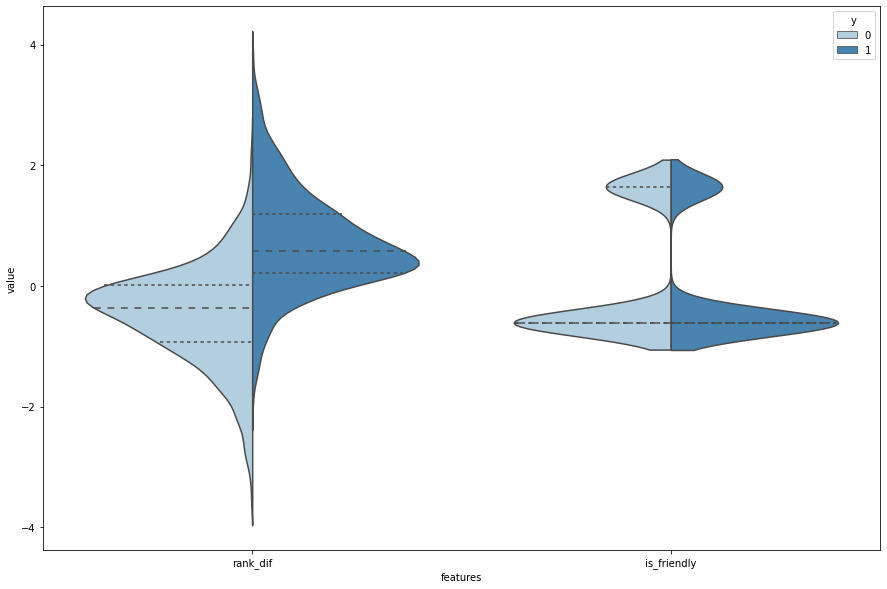

In [6]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["y"] = data1["y"]
violin1 = pd.melt(scaled,id_vars="y", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="y", data=violin1,split=True, inner="quart", palette="Blues")
plt.show()

Our Features are:
* rank_dif
* is_friendly

In [7]:
def create_db(df):
    columns = ["date","home_team", "away_team", "rank_dif","is_friendly",  "y",]    
    model_df = df.loc[:, columns]
    return model_df
model_db = create_db(df)
model_db.head()

,date,home_team,away_team,rank_dif,is_friendly,y
0,2018-08-18,Andorra,United Arab Emirates,53.0,1,1
1,2018-08-18,Grenada,Jamaica,114.0,1,1
2,2018-08-18,Guatemala,Cuba,-35.0,1,0
3,2018-08-20,Barbados,Jamaica,106.0,1,1
4,2018-08-26,Barbados,Cuba,-21.0,1,0


# 3. Data Analysis

## 3.1 Logistic Regression

In [8]:
results = {"model":[], "train":[], "test":[]}

In [9]:
predictors = ["rank_dif", "is_friendly"]
X = model_db[predictors].values
y = model_db["y"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [11]:
logit = LogisticRegression(penalty="none").fit(X_train, y_train)
results["model"].append("logistic regression")
results["train"].append(logit.score(X_train, y_train))
results["test"].append(logit.score(X_test, y_test))

In [12]:
pd.DataFrame.from_dict(results)

,model,train,test
0,logistic regression,0.801,0.804


## 3.2 Single Decision Tree Classifier

In [13]:
tree = DecisionTreeClassifier(max_depth=20).fit(X_train, y_train)
results["model"].append("single decision tree")
results["train"].append(tree.score(X_train, y_train))
results["test"].append(tree.score(X_test, y_test))

In [14]:
pd.DataFrame.from_dict(results)

,model,train,test
0,logistic regression,0.801,0.804
1,single decision tree,0.827,0.766


## 3.3  Random Forest Classifier

In [15]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }
rf = RandomForestClassifier(random_state=1)
rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)
rf_cv.fit(X_train, np.ravel(y_train))
best_rf = rf_cv.best_estimator_

In [16]:
rf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=300, max_features='sqrt').fit(X_train, y_train)
results["model"].append("random forest")
results["train"].append(best_rf.score(X_train, y_train))
results["test"].append(best_rf.score(X_test, y_test))

In [17]:
pd.DataFrame.from_dict(results)

,model,train,test
0,logistic regression,0.801,0.804
1,single decision tree,0.827,0.766
2,random forest,0.823,0.793


## 3.4 Bagging


In [18]:
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe, (2) bagging_test_df
              dataframe , and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              
    """
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [19]:
n_trees = 55
tree_depth = 20

In [20]:
bagging_train_df, bagging_test_df, bagging_models_list = bagger(n_trees = n_trees,
                                                                tree_depth = tree_depth,
                                                                X_train = X_train,
                                                                y_train =y_train,
                                                                X_test = X_test,
                                                                random_seed = 0)
pred_train= np.asarray([1 if np.sum(i) > int(55/2) else 0 for i in bagging_train_df.values])
pred_test = np.asarray([1 if np.sum(i) > int(55/2) else 0 for i in bagging_test_df.values])
bagging_accuracy_train = accuracy_score(pred_train, y_train)
bagging_accuracy_test = accuracy_score(pred_test, y_test)

In [21]:
results["model"].append("bagging")
results["train"].append(bagging_accuracy_train)
results["test"].append(bagging_accuracy_test)

In [22]:
pd.DataFrame.from_dict(results)

,model,train,test
0,logistic regression,0.801,0.804
1,single decision tree,0.827,0.766
2,random forest,0.823,0.793
3,bagging,0.827,0.763


## 3.5 Ada Boost


In [23]:
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=800, learning_rate=0.05).fit(X_train, y_train)
results["model"].append("Adaboost")
results["train"].append(boosting.score(X_train, y_train))
results["test"].append(boosting.score(X_test, y_test))

In [24]:
pd.DataFrame.from_dict(results)

,model,train,test
0,logistic regression,0.801,0.804
1,single decision tree,0.827,0.766
2,random forest,0.823,0.793
3,bagging,0.827,0.763
4,Adaboost,0.827,0.778


Based on the test score, we see that the logistic regression model achieves a larger test results, and generalises the best. Hence, we use this model to simulate the world cup.

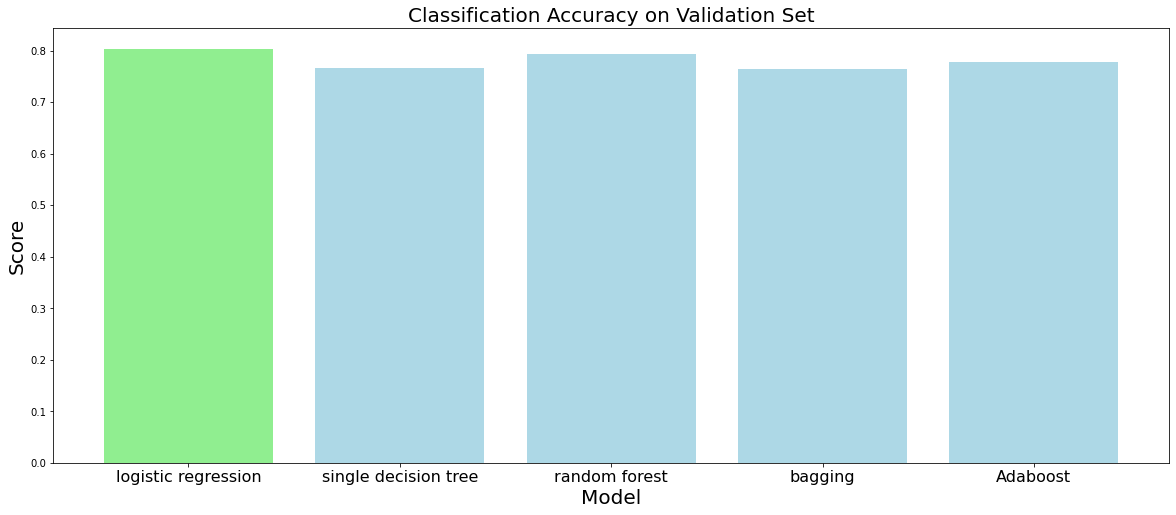

In [25]:
figure = plt.figure(figsize = (20,8))

final_dic = {results["model"][i]:results["test"][i] for i in range(5)}

plt.bar(range(len(final_dic)), list(final_dic.values()), align='center', color= 'lightblue')
plt.bar(range(1), list(final_dic.values())[:1], align='center', color= 'lightgreen')


plt.xticks(range(len(final_dic)), list(final_dic.keys()), fontsize = 16)
plt.ylabel('Score', fontsize = 20)
plt.title(f'Classification Accuracy on Validation Set', fontsize = 20)
plt.xlabel('Model', fontsize = 20)
plt.show()

# 4. Simulation

## 4. 1 Groups Round

In [26]:
table = {'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

In [28]:
matches = []
groups = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
for group in table:
    for i in range(1, 4):
        matches.append((group, table[group][0][0],table[group][i][0]))
    for i in range(1, 3):
        matches.append((group, table[group][1][0],table[group][1 + i][0]))
    for i in range(1, 2):
        matches.append((group, table[group][2][0],table[group][2 + i][0]))
matches

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Qatar', 'Netherlands'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Ecuador', 'Netherlands'),
 ('A', 'Senegal', 'Netherlands'),
 ('B', 'England', 'Iran'),
 ('B', 'England', 'United States'),
 ('B', 'England', 'Wales'),
 ('B', 'Iran', 'United States'),
 ('B', 'Iran', 'Wales'),
 ('B', 'United States', 'Wales'),
 ('C', 'Argentina', 'Saudi Arabia'),
 ('C', 'Argentina', 'Mexico'),
 ('C', 'Argentina', 'Poland'),
 ('C', 'Saudi Arabia', 'Mexico'),
 ('C', 'Saudi Arabia', 'Poland'),
 ('C', 'Mexico', 'Poland'),
 ('D', 'France', 'Australia'),
 ('D', 'France', 'Denmark'),
 ('D', 'France', 'Tunisia'),
 ('D', 'Australia', 'Denmark'),
 ('D', 'Australia', 'Tunisia'),
 ('D', 'Denmark', 'Tunisia'),
 ('E', 'Spain', 'Costa Rica'),
 ('E', 'Spain', 'Germany'),
 ('E', 'Spain', 'Japan'),
 ('E', 'Costa Rica', 'Germany'),
 ('E', 'Costa Rica', 'Japan'),
 ('E', 'Germany', 'Japan'),
 ('F', 'Belgium', 'Canada'),
 ('F', 'Belgium', 'Morocco'),
 ('F', 'Belgium',

In [29]:
def find_stats(team_1):
    #team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["home_team"] == team_1)|(team_stats_raw["away_team"] == team_1)].sort_values("date")
    team_1_rank = rank[rank["country_full"] == team_1]["rank"].values[-1]
    return [team_1_rank]

def find_features(team_1, team_2, groups):
    rank_dif = team_1[0] - team_2[0]
    if groups == True:
        return [rank_dif, 1]
    return [rank_dif, 0]

In [30]:
def simulation_16_deterministic(model = logit):
    advanced_group = []
    last_group = ""

    for k in table.keys():
        for t in table[k]:
            t[1] = 0
            t[2] = []

    for teams in matches:
        draw = False
        team_1 = find_stats(teams[1])
        team_2 = find_stats(teams[2])

        features_g1 = find_features(team_1, team_2, True)
        features_g2 = find_features(team_2, team_1, True)

        probs_g1 = model.predict_proba([features_g1])
        probs_g2 = model.predict_proba([features_g2])

        team_1_prob_g1 = probs_g1[0][0]
        team_1_prob_g2 = probs_g2[0][1]
        team_2_prob_g1 = probs_g1[0][1]
        team_2_prob_g2 = probs_g2[0][0]

        team_1_prob = (team_1_prob_g1 + team_1_prob_g2)/2
        team_2_prob = (team_2_prob_g1 + team_2_prob_g2)/2

        if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
            draw=True
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1

        elif team_1_prob > team_2_prob:
            winner = teams[1]
            winner_proba = team_1_prob
            for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[1] += 3

        elif team_2_prob > team_1_prob:  
            winner = teams[2]
            winner_proba = team_2_prob
            for i in table[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3

        for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
                if i[0] == teams[1]:
                    i[2].append(team_1_prob)
                if i[0] == teams[2]:
                    i[2].append(team_2_prob)

        if last_group != teams[0]:
            if last_group != "":
                print("\n")
                print("Group %s advanced: "%(last_group))

                for i in table[last_group]: #adding crieterio de desempate
                    i[2] = np.mean(i[2])

                final_points = table[last_group]
                final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
                advanced_group.append([final_table[0][0], final_table[1][0]])
                for i in final_table:
                    print("%s -------- %d"%(i[0], i[1]))
            print("\n")
            print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)


        if draw == False:
            print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
        else:
            print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
        last_group =  teams[0]

    print("\n")
    print("Group %s advanced: "%(last_group))

    for i in table[last_group]: #adding crieterio de desempate
        i[2] = np.mean(i[2])

    final_points = table[last_group]
    final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
    advanced_group.append([final_table[0][0], final_table[1][0]])
    for i in final_table:
        print("%s -------- %d"%(i[0], i[1]))
    return advanced_group
advanced = simulation_16_deterministic(logit)
advanced



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
England -------- 7
United States -------- 3
Wales -------- 2
Iran -------- 2


---------- Starting Analysis for Group C ----------


[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

## 4.2 Round 16 to Final

In [44]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [45]:
def Playoffs_deterministic(model = logit):
    for p in playoffs.keys():
        playoffs[p] = []

    actual_round = ""
    next_rounds = []

    for p in playoffs.keys():
        if p == "Round of 16":
            control = []
            for a in range(0, len(advanced*2), 1):
                if a < len(advanced):
                    if a % 2 == 0:
                        control.append((advanced*2)[a][0])
                    else:
                        control.append((advanced*2)[a][1])
                else:
                    if a % 2 == 0:
                        control.append((advanced*2)[a][1])
                    else:
                        control.append((advanced*2)[a][0])

            playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]

            for i in range(0, len(playoffs[p]), 1):
                game = playoffs[p][i]

                home = game[0]
                away = game[1]
                team_1 = find_stats(home)
                team_2 = find_stats(away)

                features_g1 = find_features(team_1, team_2, False)
                features_g2 = find_features(team_2, team_1, False)

                probs_g1 = model.predict_proba([features_g1])
                probs_g2 = model.predict_proba([features_g2])

                team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
                team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2

                if actual_round != p:
                    print("-"*10)
                    print("Starting simulation of %s"%(p))
                    print("-"*10)
                    print("\n")

                if team_1_prob < team_2_prob:
                    print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)

                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p

        else:
            playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
            next_rounds = []
            for i in range(0, len(playoffs[p])):
                game = playoffs[p][i]
                home = game[0]
                away = game[1]
                team_1 = find_stats(home)
                team_2 = find_stats(away)

                features_g1 = find_features(team_1, team_2, False)
                features_g2 = find_features(team_2, team_1, False)

                probs_g1 = model.predict_proba([features_g1])
                probs_g2 = model.predict_proba([features_g2])

                team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
                team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2

                if actual_round != p:
                    print("-"*10)
                    print("Starting simulation of %s"%(p))
                    print("-"*10)
                    print("\n")

                if team_1_prob < team_2_prob:
                    print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p
    return playoffs
_ = Playoffs_deterministic(logit)

----------
Starting simulation of Round of 16
----------


Netherlands vs. Wales: Netherlands advances with prob 0.60
Poland vs. France: France advances with prob 0.69
Japan vs. Croatia: Croatia advances with prob 0.61
Brazil vs. Portugal: Brazil advances with prob 0.57
Senegal vs. England: England advances with prob 0.62
Mexico vs. Tunisia: Mexico advances with prob 0.65
Spain vs. Morocco: Spain advances with prob 0.63
Cameroon vs. South Korea: South Korea advances with prob 0.63
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. France: France advances with prob 0.54
Croatia vs. Brazil: Brazil advances with prob 0.60
England vs. Mexico: England advances with prob 0.57
Spain vs. South Korea: Spain advances with prob 0.68
----------
Starting simulation of Semi-Final
----------


France vs. Brazil: Brazil advances with prob 0.53
England vs. Spain: England advances with prob 0.52
----------
Starting simulation of Final
----------


Brazil vs. England: Brazil adv

# 5. Adding Stochasticty to our model


Here, at every game played, 50% of the time we will make the underdog win the game in order to simulate major upsets.

In [70]:
def simulation_16(model = logit):
    advanced_group = []
    last_group = ""

    for k in table.keys():
        for t in table[k]:
            t[1] = 0
            t[2] = []

    for teams in matches:
        draw = False
        team_1 = find_stats(teams[1])
        team_2 = find_stats(teams[2])

        features_g1 = find_features(team_1, team_2, groups = True)
        features_g2 = find_features(team_2, team_1, groups = True)

        probs_g1 = model.predict_proba([features_g1])
        probs_g2 = model.predict_proba([features_g2])

        team_1_prob_g1 = probs_g1[0][0]
        team_1_prob_g2 = probs_g2[0][1]
        team_2_prob_g1 = probs_g1[0][1]
        team_2_prob_g2 = probs_g2[0][0]

        team_1_prob = (team_1_prob_g1 + team_1_prob_g2)/2
        team_2_prob = (team_2_prob_g1 + team_2_prob_g2)/2
        
        
        ########## adding randomness (or luck ?) ###########
        crit = np.random.uniform(0,1)
        ####################################################
        if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
            draw=True
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1
        
        elif team_1_prob > team_2_prob:
            winner = teams[1]
            winner_proba = team_1_prob
            #adding randomness
            if crit > 0.5:
                for i in table[teams[0]]:
                    if i[0] == teams[1]:
                        i[1] += 3
            for i in table[teams[0]]:
                    if i[0] == teams[2]:
                        i[1] += 3

        elif team_2_prob > team_1_prob:  
            winner = teams[2]
            winner_proba = team_2_prob
            for i in table[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3

        for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
                if i[0] == teams[1]:
                    i[2].append(team_1_prob)
                if i[0] == teams[2]:
                    i[2].append(team_2_prob)

        if last_group != teams[0]:
            if last_group != "":
                print("\n")
                print("Group %s advanced: "%(last_group))

                for i in table[last_group]: #adding crieterio de desempate
                    i[2] = np.mean(i[2])

                final_points = table[last_group]
                final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
                advanced_group.append([final_table[0][0], final_table[1][0]])
                for i in final_table:
                    print("%s -------- %d"%(i[0], i[1]))
            print("\n")
            print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)


        if draw == False:
            print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
        else:
            print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
        last_group =  teams[0]

    print("\n")
    print("Group %s advanced: "%(last_group))

    for i in table[last_group]: #adding crieterio de desempate
        i[2] = np.mean(i[2])

    final_points = table[last_group]
    final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
    advanced_group.append([final_table[0][0], final_table[1][0]])
    for i in final_table:
        print("%s -------- %d"%(i[0], i[1]))
    return advanced_group
advanced = simulation_16(logit)
advanced



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
England -------- 4
United States -------- 3


---------- Starting Analysis for Group C ----------


[['Netherlands', 'Senegal'],
 ['Wales', 'Iran'],
 ['Poland', 'Mexico'],
 ['Tunisia', 'Denmark'],
 ['Spain', 'Japan'],
 ['Morocco', 'Croatia'],
 ['Cameroon', 'Serbia'],
 ['South Korea', 'Uruguay']]

In [71]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [72]:
def Playoffs(model = logit):
    for p in playoffs.keys():
        playoffs[p] = []

    actual_round = ""
    next_rounds = []

    for p in playoffs.keys():
        if p == "Round of 16":
            control = []
            for a in range(0, len(advanced*2), 1):
                if a < len(advanced):
                    if a % 2 == 0:
                        control.append((advanced*2)[a][0])
                    else:
                        control.append((advanced*2)[a][1])
                else:
                    if a % 2 == 0:
                        control.append((advanced*2)[a][1])
                    else:
                        control.append((advanced*2)[a][0])

            playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]

            for i in range(0, len(playoffs[p]), 1):
                game = playoffs[p][i]

                home = game[0]
                away = game[1]
                team_1 = find_stats(home)
                team_2 = find_stats(away)

                features_g1 = find_features(team_1, team_2, False)
                features_g2 = find_features(team_2, team_1, False)

                probs_g1 = model.predict_proba([features_g1])
                probs_g2 = model.predict_proba([features_g2])

                team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
                team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2

                if actual_round != p:
                    print("-"*10)
                    print("Starting simulation of %s"%(p))
                    print("-"*10)
                    print("\n")

                if team_1_prob < team_2_prob:
                    print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)

                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p

        else:
            playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
            next_rounds = []
            for i in range(0, len(playoffs[p])):
                game = playoffs[p][i]
                home = game[0]
                away = game[1]
                team_1 = find_stats(home)
                team_2 = find_stats(away)

                features_g1 = find_features(team_1, team_2, False)
                features_g2 = find_features(team_2, team_1, False)

                probs_g1 = model.predict_proba([features_g1])
                probs_g2 = model.predict_proba([features_g2])

                team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
                team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2

                if actual_round != p:
                    print("-"*10)
                    print("Starting simulation of %s"%(p))
                    print("-"*10)
                    print("\n")

                if team_1_prob < team_2_prob:
                    print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p
    return playoffs
p = Playoffs(logit)

----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances with prob 0.61
Poland vs. Denmark: Denmark advances with prob 0.64
Spain vs. Croatia: Spain advances with prob 0.54
Cameroon vs. Uruguay: Uruguay advances with prob 0.74
Senegal vs. Wales: Senegal advances with prob 0.51
Mexico vs. Tunisia: Mexico advances with prob 0.65
Japan vs. Morocco: Morocco advances with prob 0.52
Serbia vs. South Korea: Serbia advances with prob 0.56
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Denmark: Netherlands advances with prob 0.52
Spain vs. Uruguay: Spain advances with prob 0.56
Senegal vs. Mexico: Mexico advances with prob 0.54
Morocco vs. Serbia: Serbia advances with prob 0.51
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Spain: Spain advances with prob 0.51
Mexico vs. Serbia: Mexico advances with prob 0.57
----------
Starting simulation of Final
----------


Spain vs. Mexico: Spain advances 

# 7. Measuring stochasticity and distribution of worldcup winners outcomes

In [73]:
iterations = 100
countriesWC = []

for i in table:
    countries_group = [country[0] for country in table[i]]
    countriesWC += countries_group
countries_dic = {i:0 for i in countriesWC}
second_dic = {i:0 for i in countriesWC}

In [74]:
for ite in range(iterations):
    advanced = simulation_16(logit)
    final = Playoffs(logit)["Final"][0]
    team1 = final[0]
    team2 = final[1]
    p1 = final[2][0]
    p2 = final[2][1]
    print(p1)
    if p1 > p2:
        countries_dic[team1] += 1
        second_dic[team2] += 1
    else:
        countries_dic[team2] += 1
        second_dic[team1] += 1



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
England -------- 7
Wales -------- 5
Iran -------- 5
United States -------- 3


---------- Starting Analysis for Group C ----------


Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Switzerland -------- 4
Serbia -------- 4
Brazil -------- 0


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Portugal -------- 4
Uruguay -------- 4
Ghana -------- 3
----------
Starting simulation of R

Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 7
Mexico -------- 7
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Denmark -------- 7
Tunisia -------- 7
Australia -------- 4
France -------- 1


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - G

----------
Starting simulation of Quarter-Final
----------


Netherlands vs. France: France advances with prob 0.54
Germany vs. Portugal: Portugal advances with prob 0.52
England vs. Argentina: Argentina advances with prob 0.52
Morocco vs. Brazil: Brazil advances with prob 0.68
----------
Starting simulation of Semi-Final
----------


France vs. Portugal: France advances with prob 0.54
Argentina vs. Brazil: Brazil advances with prob 0.52
----------
Starting simulation of Final
----------


France vs. Brazil: Brazil advances with prob 0.53
0.4730163382935094


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Net

Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Morocco -------- 7
Croatia -------- 5
Belgium -------- 4
Canada -------- 3


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Switzerland -------- 7
Serbia -------- 4
Brazil -------- 3


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: 

Group B - United States vs. Wales: Draw


Group B advanced: 
England -------- 7
Wales -------- 5
Iran -------- 5
United States -------- 3


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - Argentina vs. Mexico: Draw
Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 7
Mexico -------- 7
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia v

Germany vs. Morocco: Germany advances with prob 0.60
Cameroon vs. Portugal: Portugal advances with prob 0.77
Senegal vs. Wales: Senegal advances with prob 0.51
Argentina vs. Denmark: Argentina advances with prob 0.56
Japan vs. Belgium: Belgium advances with prob 0.69
Switzerland vs. South Korea: Switzerland advances with prob 0.62
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Poland: Netherlands advances with prob 0.66
Germany vs. Portugal: Portugal advances with prob 0.52
Senegal vs. Argentina: Argentina advances with prob 0.63
Belgium vs. Switzerland: Belgium advances with prob 0.62
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Portugal: Netherlands advances with prob 0.51
Argentina vs. Belgium: Belgium advances with prob 0.51
----------
Starting simulation of Final
----------


Netherlands vs. Belgium: Belgium advances with prob 0.55
0.4461827188767633


---------- Starting Analysis for Group A ----------
Group A - Qatar vs.

Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Japan -------- 7
Germany -------- 4
Costa Rica -------- 4
Spain -------- 1


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Morocco -------- 7
Croatia -------- 5
Canada -------- 3
Belgium -------- 1


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.

Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
England -------- 7
Wales -------- 5
Iran -------- 5
United States -------- 3


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - Argentina vs. Mexico: Draw
Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 4
Mexico -------- 4
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - Fran

Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 7
Portugal -------- 4
Ghana -------- 3
----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances with prob 0.61
Poland vs. Tunisia: Poland advances with prob 0.54
Japan vs. Croatia: Croatia advances with prob 0.61
Cameroon vs. Uruguay: Uruguay advances with prob 0.74
Senegal vs. Wales: Senegal advances with prob 0.51
Mexico vs. Denmark: Denmark advances with prob 0.53
Spain vs. Morocco: Spain advances with prob 0.63
Switzerland vs. South Korea: Switzerland advances with prob 0.62
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Poland: Netherlands advances with prob 0.66
Croatia vs. Uruguay: Croatia advances with prob 0.52
Senegal vs. Denmark: Denmark advances with prob 0.57
Spain vs. Switzerland: Spain advances

Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Tunisia -------- 7
France -------- 4
Denmark -------- 4
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Germany -------- 7
Japan -------- 7
Spain -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada 



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
England -------- 4
United States -------- 3


---------- Starting Analysis for Group C ----------


Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Brazil -------- 9
Cameroon -------- 9
Switzerland -------- 7
Serbia -------- 4


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 4
Ghana -------- 3
Portugal -------- 1
----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances with prob 0.61
Poland vs. Denmark: Denmark advances with prob 0.64
Japan vs. Croatia: Croatia advances with p



Group C advanced: 
Poland -------- 9
Mexico -------- 7
Saudi Arabia -------- 3
Argentina -------- 1


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Tunisia -------- 7
Denmark -------- 4
Australia -------- 4
France -------- 1


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E 

Senegal vs. Argentina: Argentina advances with prob 0.63
Morocco vs. Switzerland: Switzerland advances with prob 0.56
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Spain: Spain advances with prob 0.51
Argentina vs. Switzerland: Argentina advances with prob 0.61
----------
Starting simulation of Final
----------


Spain vs. Argentina: Argentina advances with prob 0.54
0.46404777700141275


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England

Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Serbia -------- 7
Switzerland -------- 4
Brazil -------- 3


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 4
Ghana -------- 3
Portugal -------- 1
----------
Starting simulation of R

Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Mexico -------- 7
Argentina -------- 4
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Denmark -------- 7
Tunisia -------- 7
France -------- 4
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain

Argentina vs. Tunisia: Argentina advances with prob 0.73
Japan vs. Morocco: Morocco advances with prob 0.52
Switzerland vs. South Korea: Switzerland advances with prob 0.62
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. France: France advances with prob 0.54
Spain vs. Portugal: Spain advances with prob 0.52
England vs. Argentina: Argentina advances with prob 0.52
Morocco vs. Switzerland: Switzerland advances with prob 0.56
----------
Starting simulation of Semi-Final
----------


France vs. Spain: France advances with prob 0.53
Argentina vs. Switzerland: Argentina advances with prob 0.61
----------
Starting simulation of Final
----------


France vs. Argentina: Argentina advances with prob 0.51
0.4909980068689105


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador v

Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Japan -------- 7
Spain -------- 4
Germany -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Morocco -------- 7
Croatia -------- 5
Canada -------- 3
Belgium -------- 1


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbi

Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
United States -------- 3
England -------- 1


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - Argentina vs. Mexico: Draw
Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 7
Mexico -------- 4
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - Fran

Cameroon vs. Portugal: Portugal advances with prob 0.77
Senegal vs. Wales: Senegal advances with prob 0.51
Argentina vs. France: Argentina advances with prob 0.51
Spain vs. Morocco: Spain advances with prob 0.63
Switzerland vs. South Korea: Switzerland advances with prob 0.62
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Denmark: Netherlands advances with prob 0.52
Croatia vs. Portugal: Portugal advances with prob 0.53
Senegal vs. Argentina: Argentina advances with prob 0.63
Spain vs. Switzerland: Spain advances with prob 0.57
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Portugal: Netherlands advances with prob 0.51
Argentina vs. Spain: Argentina advances with prob 0.54
----------
Starting simulation of Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.54
0.4551014186642658


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Sene

Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Japan -------- 7
Spain -------- 4
Germany -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Morocco -------- 7
Croatia -------- 5
Belgium -------- 4
Canada -------- 3


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbi

Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
England -------- 4
United States -------- 3


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - Argentina vs. Mexico: Draw
Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Mexico -------- 7
Saudi Arabia -------- 3
Argentina -------- 1


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia v

Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Portugal -------- 4
Uruguay -------- 4
Ghana -------- 3
----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances with prob 0.61
Poland vs. Tunisia: Poland advances with prob 0.54
Spain vs. Croatia: Spain advances with prob 0.54
Cameroon vs. Portugal: Portugal advances with prob 0.77
Senegal vs. Wales: Senegal advances with prob 0.51
Mexico vs. Denmark: Denmark advances with prob 0.53
Germany vs. Morocco: Germany advances with prob 0.60
Switzerland vs. South Korea: Switzerland advances with prob 0.62
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Poland: Netherlands advances with prob 0.66
Spain vs. Portugal: Spain advances with prob 0.52
Senegal vs. Denmark: Denmark advances with prob 0.57
Germany vs. Switzerland: Germany adv



Group D advanced: 
Tunisia -------- 7
France -------- 4
Denmark -------- 4
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Japan -------- 7
Spain -------- 4
Germany -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 

----------
Starting simulation of Final
----------


Netherlands vs. France: France advances with prob 0.54
0.46404777700141275


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wal

Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Switzerland -------- 7
Brazil -------- 6
Serbia -------- 4


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 4
Ghana -------- 3
Portugal -------- 1
----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances with prob 0.61
Poland vs. France: France advances with prob 0.69
Germany vs. Croatia: Germany advances with p

Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Denmark -------- 7
Tunisia -------- 7
France -------- 4
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Germany -------- 7
Japan -------- 7
Spain -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada 

Denmark vs. Spain: Spain advances with prob 0.53
----------
Starting simulation of Final
----------


Netherlands vs. Spain: Spain advances with prob 0.51
0.4909980068689105


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United S

Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Switzerland -------- 7
Serbia -------- 4
Brazil -------- 3


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 7
Ghana -------- 3
Portugal -------- 1
----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances wit

Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Tunisia -------- 7
France -------- 4
Denmark -------- 4
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Germany -------- 7
Japan -------- 7
Costa Rica -------- 4
Spain -------- 1


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0

Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
England -------- 4
United States -------- 3


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - A

Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Serbia -------- 7
Switzerland -------- 4
Brazil -------- 3


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Portugal -------- 7
Uruguay -------- 7
Ghana -------- 3
----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances with prob 0.61
Poland vs. Tunisia: Poland advances with prob 0.54
Spain vs. Croatia: Spain advances with prob 0.54
Cameroon vs. Portugal: Portugal advances with prob 0.77
Seneg

Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 7
Mexico -------- 4
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
France -------- 7
Denmark -------- 7
Tunisia -------- 7
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - G

Germany vs. Portugal: Portugal advances with prob 0.52
England vs. Mexico: England advances with prob 0.57
Morocco vs. Switzerland: Switzerland advances with prob 0.56
----------
Starting simulation of Semi-Final
----------


France vs. Portugal: France advances with prob 0.54
England vs. Switzerland: England advances with prob 0.59
----------
Starting simulation of Final
----------


France vs. England: France advances with prob 0.51
0.5090019931310895


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis 

Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Belgium -------- 7
Morocco -------- 7
Croatia -------- 5
Canada -------- 3


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Serbia -------- 7
Brazil -------- 6
Switzerland -------- 4


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: 

Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Mexico -------- 4
Saudi Arabia -------- 3
Argentina -------- 1


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Denmark -------- 7
Tunisia -------- 7
Australia -------- 4
France -------- 1


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany

Germany vs. Portugal: Portugal advances with prob 0.52
Senegal vs. Denmark: Denmark advances with prob 0.57
Morocco vs. Switzerland: Switzerland advances with prob 0.56
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Portugal: Netherlands advances with prob 0.51
Denmark vs. Switzerland: Denmark advances with prob 0.54
----------
Starting simulation of Final
----------


Netherlands vs. Denmark: Netherlands advances with prob 0.52
0.5179984036443275


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


--------

Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Morocco -------- 7
Croatia -------- 5
Belgium -------- 4
Canada -------- 3


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Serbia -------- 7
Switzerland -------- 4
Brazil -------- 0


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner 

Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
United States -------- 3
England -------- 1


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - Argentina vs. Mexico: Draw
Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 7
Mexico -------- 7
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - Fran

Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 7
Ghana -------- 3
Portugal -------- 1
----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances with prob 0.61
Poland vs. Tunisia: Poland advances with prob 0.54
Germany vs. Morocco: Germany advances with prob 0.60
Cameroon vs. Uruguay: Uruguay advances with prob 0.74
Senegal vs. Wales: Senegal advances with prob 0.51
Argentina vs. Denmark: Argentina advances with prob 0.56
Japan vs. Belgium: Belgium advances with prob 0.69
Serbia vs. South Korea: Serbia advances with prob 0.56
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Poland: Netherlands advances with prob 0.66
Germany vs. Uruguay: Germany advances with prob 0.53
Senegal vs. Argentina: Argentina advances with prob 0.63
Belgium vs. Serbia: Belgium advances with prob 0.66
----------
Starting simulation of Semi-Final
----------


Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Tunisia -------- 7
Denmark -------- 4
Australia -------- 4
France -------- 1


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Japan -------- 7
Spain -------- 4
Germany -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 

Argentina vs. Spain: Argentina advances with prob 0.54
----------
Starting simulation of Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.54
0.4551014186642658


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Grou

Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Cameroon -------- 9
Serbia -------- 7
Brazil -------- 6
Switzerland -------- 4


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 7
Portugal -------- 4
Ghana -------- 3
----------
Starting simulation of R

Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 7
Mexico -------- 7
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Denmark -------- 7
Tunisia -------- 7
France -------- 4
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Gr

Brazil vs. Uruguay: Brazil advances with prob 0.62
Senegal vs. Wales: Senegal advances with prob 0.51
Argentina vs. France: Argentina advances with prob 0.51
Japan vs. Morocco: Morocco advances with prob 0.52
Cameroon vs. South Korea: South Korea advances with prob 0.63
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Poland: Netherlands advances with prob 0.66
Germany vs. Brazil: Brazil advances with prob 0.59
Senegal vs. Argentina: Argentina advances with prob 0.63
Morocco vs. South Korea: Morocco advances with prob 0.55
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.56
Argentina vs. Morocco: Argentina advances with prob 0.66
----------
Starting simulation of Final
----------


Brazil vs. Argentina: Brazil advances with prob 0.52
0.5179984036443275


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probab

Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Spain -------- 7
Japan -------- 7
Germany -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Morocco -------- 7
Croatia -------- 5
Belgium -------- 4
Canada -------- 3


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbi



Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
England -------- 4
United States -------- 3


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - Argentina vs. Mexico: Draw
Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 

Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 7
Portugal -------- 4
Ghana -------- 3
----------
Starting simulation of Round of 16
----------


Netherlands vs. Iran: Netherlands advances with prob 0.61
Poland vs. Tunisia: Poland advances with prob 0.54
Germany vs. Croatia: Germany advances with prob 0.51
Brazil vs. Uruguay: Brazil advances with prob 0.62
Senegal vs. Wales: Senegal advances with prob 0.51
Argentina vs. France: Argentina advances with prob 0.51
Japan vs. Morocco: Morocco advances with prob 0.52
Cameroon vs. South Korea: South Korea advances with prob 0.63
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Poland: Netherlands advances with prob 0.66
Germany vs. Brazil: Brazil advances with prob 0.59
Senegal vs. Argentina: Argentina advances with prob 0.63
Morocco vs. South Korea: Morocco 



Group D advanced: 
Tunisia -------- 7
France -------- 4
Denmark -------- 4
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Japan -------- 7
Spain -------- 4
Germany -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 

Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
England -------- 4
United States -------- 3


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - Argentina vs. Mexico: Draw
Group C - Argentina vs. Poland: Winner A

Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Portugal -------- 4
Uruguay -------- 4
Ghana -------- 3
----------
Starting simulation of Round of 16
----------


Netherlands vs. Wales: Netherlands advances with prob 0.60
Poland vs. Denmark: Denmark advances with prob 0.64
Germany vs. Morocco: Germany advances with prob 0.60
Cameroon vs. Portugal: Portugal advances with prob 0.77
Senegal vs. England: England advances with prob 0.62
Argentina vs. Tunisia: Argentina advances with prob 0.73
Japan vs. Belgium: Belgium advances with prob 0.69
Serbia vs. South Korea: Serbia advances with prob 0.56
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Denmark: Netherlands advances with prob 0.52
Germany vs. Portugal: Portugal advances with prob 0.52
England vs. Arge

Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
France -------- 7
Tunisia -------- 7
Denmark -------- 4
Australia -------- 4


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Group E - Spain vs. Germany: Draw
Group E - Spain vs. Japan: Winner Spain with 0.65 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Spain -------- 7
Germany -------- 7
Japan -------- 7
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.78 probability
Group A - Senegal vs. Netherlands: Draw


Group A advanced: 
Netherlands -------- 7
Senegal -------- 7
Ecuador -------- 1
Qatar -------- 1


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - England vs. United States: Draw
Group B - England vs. Wales: Winner England with 0.62 probability
Group B - Iran vs. United States: Draw
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
Wales -------- 5
Iran -------- 5
England -------- 4
United States -------- 3


---------- Starting Analysis for Group C ----------


Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Brazil -------- 9
Cameroon -------- 9
Switzerland -------- 4
Serbia -------- 4


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw
Group H - Portugal vs. South Korea: Winner Portugal with 0.66 probability
Group H - Ghana vs. Uruguay: Winner Uruguay with 0.84 probability
Group H - Ghana vs. South Korea: Winner South Korea with 0.76 probability
Group H - Uruguay vs. South Korea: Winner Uruguay with 0.62 probability


Group H advanced: 
South Korea -------- 9
Uruguay -------- 7
Portugal -------- 4
Ghana -------- 3
----------
Starting simulation of R

Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 7
Mexico -------- 7
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 probability
Group D - Australia vs. Tunisia: Draw
Group D - Denmark vs. Tunisia: Winner Denmark with 0.67 probability


Group D advanced: 
Tunisia -------- 7
Denmark -------- 4
Australia -------- 4
France -------- 1


---------- Starting Analysis for Group E ----------
Group E - Spain vs. Costa Rica: Winner Spain with 0.70 probability
Gr

Mexico vs. Tunisia: Mexico advances with prob 0.65
Japan vs. Morocco: Morocco advances with prob 0.52
Brazil vs. South Korea: Brazil advances with prob 0.73
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. France: France advances with prob 0.54
Spain vs. Uruguay: Spain advances with prob 0.56
Senegal vs. Mexico: Mexico advances with prob 0.54
Morocco vs. Brazil: Brazil advances with prob 0.68
----------
Starting simulation of Semi-Final
----------


France vs. Spain: France advances with prob 0.53
Mexico vs. Brazil: Brazil advances with prob 0.61
----------
Starting simulation of Final
----------


France vs. Brazil: Brazil advances with prob 0.53
0.4730163382935094


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group A - Qatar vs. Senegal: Winner Senegal with 0.76 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.82 probability
Group A - Ecuador vs. Senegal: Winner Senegal with 0.72 probability
G

Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Belgium -------- 7
Morocco -------- 7
Croatia -------- 5
Canada -------- 3


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 0.82 probability
Group G - Serbia vs. Switzerland: Draw
Group G - Serbia vs. Cameroon: Winner Serbia with 0.69 probability
Group G - Switzerland vs. Cameroon: Winner Switzerland with 0.73 probability


Group G advanced: 
Brazil -------- 9
Cameroon -------- 9
Switzerland -------- 7
Serbia -------- 4


---------- Starting Analysis for Group H ----------
Group H - Portugal vs. Ghana: Winner Portugal with 0.87 probability
Group H - Portugal vs. Uruguay: Draw


Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
England -------- 7
Wales -------- 5
Iran -------- 5
United States -------- 3


---------- Starting Analysis for Group C ----------
Group C - Argentina vs. Saudi Arabia: Winner Argentina with 0.85 probability
Group C - Argentina vs. Mexico: Draw
Group C - Argentina vs. Poland: Winner Argentina with 0.69 probability
Group C - Saudi Arabia vs. Mexico: Winner Mexico with 0.79 probability
Group C - Saudi Arabia vs. Poland: Winner Poland with 0.71 probability
Group C - Mexico vs. Poland: Winner Mexico with 0.61 probability


Group C advanced: 
Poland -------- 9
Argentina -------- 4
Mexico -------- 4
Saudi Arabia -------- 3


---------- Starting Analysis for Group D ----------
Group D - France vs. Australia: Winner France with 0.77 probability
Group D - France vs. Denmark: Draw
Group D - France vs. Tunisia: Winner France with 0.72 probability
Group D - Australia vs. Denmark: Winner Denmark with 0.73 pr

Japan vs. Morocco: Morocco advances with prob 0.52
Cameroon vs. Uruguay: Uruguay advances with prob 0.74
Senegal vs. England: England advances with prob 0.62
Argentina vs. Denmark: Argentina advances with prob 0.56
Spain vs. Belgium: Belgium advances with prob 0.54
Serbia vs. South Korea: Serbia advances with prob 0.56
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Poland: Netherlands advances with prob 0.66
Morocco vs. Uruguay: Uruguay advances with prob 0.57
England vs. Argentina: Argentina advances with prob 0.52
Belgium vs. Serbia: Belgium advances with prob 0.66
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Uruguay: Netherlands advances with prob 0.55
Argentina vs. Belgium: Belgium advances with prob 0.51
----------
Starting simulation of Final
----------


Netherlands vs. Belgium: Belgium advances with prob 0.55
0.4461827188767633


---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Draw
Group

Group E - Costa Rica vs. Germany: Winner Germany with 0.67 probability
Group E - Costa Rica vs. Japan: Draw
Group E - Germany vs. Japan: Winner Germany with 0.61 probability


Group E advanced: 
Germany -------- 7
Japan -------- 7
Spain -------- 4
Costa Rica -------- 4


---------- Starting Analysis for Group F ----------
Group F - Belgium vs. Canada: Winner Belgium with 0.80 probability
Group F - Belgium vs. Morocco: Winner Belgium with 0.67 probability
Group F - Belgium vs. Croatia: Draw
Group F - Canada vs. Morocco: Winner Morocco with 0.66 probability
Group F - Canada vs. Croatia: Winner Croatia with 0.74 probability
Group F - Morocco vs. Croatia: Draw


Group F advanced: 
Morocco -------- 7
Croatia -------- 5
Belgium -------- 4
Canada -------- 3


---------- Starting Analysis for Group G ----------
Group G - Brazil vs. Serbia: Winner Brazil with 0.67 probability
Group G - Brazil vs. Switzerland: Winner Brazil with 0.62 probability
Group G - Brazil vs. Cameroon: Winner Brazil with 

In [76]:
def make_dic(countries_dic):
    dic = {i:countries_dic[i] for i in countries_dic if countries_dic[i]!= 0}
    dic = sorted(dic.items(), key=lambda x:x[1], reverse = True)
    dic = {i[0]:i[1] for i in dic}
    return dic

In [77]:
dic_winner = make_dic(countries_dic)
dic_seconds = make_dic(second_dic)

In [78]:
def plot(final_dic):
    figure = plt.figure(figsize = (20,8))
    plt.bar(range(len(final_dic)), list(final_dic.values()), align='center', color= 'r',alpha = 0.3 ,label = 'eliminated')
    plt.bar(range(len(final_dic))[:1], list(final_dic.values())[:1], align='center', color= 'b', alpha = 0.7)
    plt.bar(range(len(final_dic))[3:4], list(final_dic.values())[3:4], align='center',color= 'blue',alpha = 0.7, label = 'still in the competition')
    plt.xticks(range(len(final_dic)), list(final_dic.keys()))
    plt.ylabel('Counts', fontsize = 20)
    plt.title(f'Distribution of 2022 worldcup wins over {iterations} iterations', fontsize = 20)
    plt.xlabel('Country', fontsize = 20)
    plt.savefig('distribution of winners')
    plt.legend(fontsize = 20)
    plt.show()

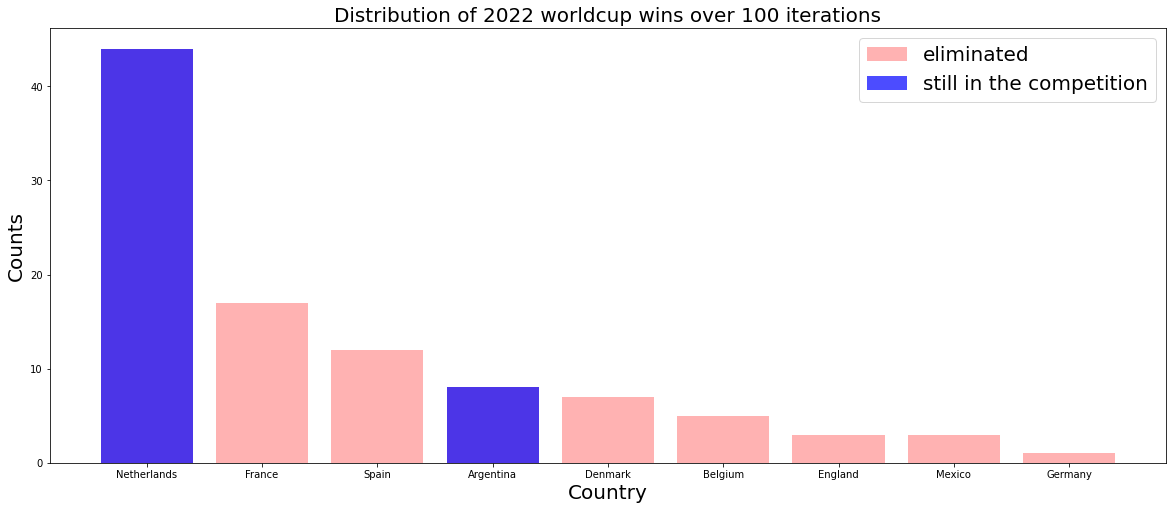

In [79]:
plot(dic_seconds)

In [ ]:
final_dic = {i:countries_dic[i] for i in countries_dic if countries_dic[i]!= 0}
final_dic =  sorted(final_dic.items(), key=lambda x:x[1], reverse = True)
final_dic = {i[0]:i[1] for i in final_dic}

In [194]:
final_dic_gold = final_dic.copy()

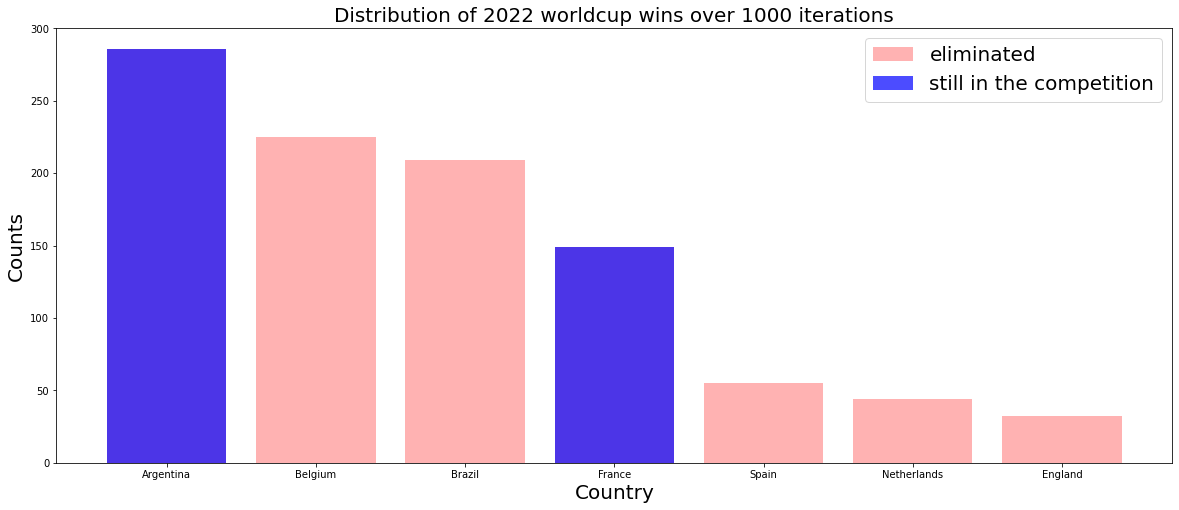

In [187]:
figure = plt.figure(figsize = (20,8))

plt.bar(range(len(final_dic)), list(final_dic.values()), align='center', color= 'r',alpha = 0.3 ,label = 'eliminated')
plt.bar(range(len(final_dic))[:1], list(final_dic.values())[:1], align='center', color= 'b', alpha = 0.7)
plt.bar(range(len(final_dic))[3:4], list(final_dic.values())[3:4], align='center',color= 'blue',alpha = 0.7, label = 'still in the competition')
plt.xticks(range(len(final_dic)), list(final_dic.keys()))
plt.ylabel('Counts', fontsize = 20)
plt.title(f'Distribution of 2022 worldcup wins over {iterations} iterations', fontsize = 20)
plt.xlabel('Country', fontsize = 20)
plt.savefig('distribution of winners')
plt.legend(fontsize = 20)
plt.show()